# Terrence Thesis - Case Study
***(Weekly Stress Period) Time Frame 2005-2014--- Changed grid size***

### Import Statements

In [1]:
import flopy
import flopy.modflow as mf
import flopy.utils as fu
import flopy.utils.binaryfile as bf
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import shutil
import sys
import datetime
import math
from sklearn.metrics import mean_squared_error as mse
import flopy.mt3d as mt3
from flopy.export import vtk
import itertools as it
%matplotlib inline

### Setup folder where modflow-files are located

In [2]:
workspace = os.path.join('mf-data-weekly-grid')

In [3]:
if os.path.exists(workspace):
    shutil.rmtree(workspace)

if not os.path.exists(workspace):
    os.makedirs(workspace)

### Print versions

In [4]:
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('pandas version: {}'.format(pd.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.7 (v3.6.7:6ec5cf24b7, Oct 20 2018, 13:35:33) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.14.3
pandas version: 0.23.4
matplotlib version: 3.0.2
flopy version: 3.2.10


### Setup MF-Package

In [5]:
modelname = 'model'
exe_name = 'mf2005'

if platform.system() == 'Windows':
    exe_name += '.exe'

In [6]:
tm = mf.Modflow(modelname=modelname, exe_name=exe_name, version='mf2005', model_ws=workspace)

### Setup Discretization Package

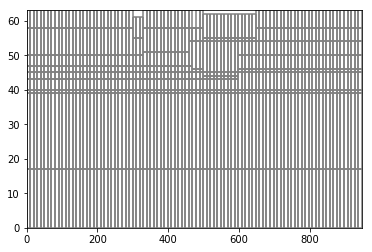

In [7]:
nrow = 1
ncol = 95
nlay = 10-1

Lx = 950
Ly = 1

botm = np.ones ( (nlay, nrow, ncol), dtype=np.int32 )
top = 63 * np.ones ( (nrow, ncol), dtype=np.int32 )

# Range does not include upper bound !!!
for i in range ( 30, 33):
    top[ :, i ] = 31+30
for i in range ( 47, 48 ):
    top[ :, i ] = 28+30
for i in range ( 50, 65):
    top[ :, i ] = 32+30

# N1 layer
botm[ 0, :, : ] = 28+30
for i in range ( 30, 33):
    botm[ 0,:, i ] = 25+30
for i in range ( 50, 65):
    botm[ 0,:, i ] = 25+30
## N2 layer
for i in range ( 0, 33 ):
    botm[ 1, :, i ] = 20+30
for i in range ( 33, 46 ):
    botm[ 1, :, i ] = 21.5+30
for i in range ( 46, 48 ):
    botm[ 1, :, i ] = 24+30
for i in range ( 48, ncol ):
    botm[ 1, :, i ] = 24.5+30
# N3 layer
for i in range ( 0, 47 ):
    botm[ 2, :, i ] = 17+30
for i in range ( 47, 50 ):
    botm[ 2, :, i ] = 16+30
for i in range ( 50, 60 ):
    botm[ 2, :, i ] = 15+30
for i in range ( 60, ncol ):
    botm[ 2, :, i ] = 20+30
# N4 layer
for i in range ( 0, 50 ):
    botm[ 3, :, i ] = 15+30
for i in range ( 50, 60 ):
    botm[ 3, :, i ] = 14+30
for i in range ( 60, ncol ):
    botm[ 3, :, i ] = 16+30
# N5 layer
for i in range ( 0, 60 ):
    botm[ 4, :, i ] = 13+30
for i in range ( 60, ncol ):
    botm[ 4, :, i ] = 15+30
# 6 layer
botm[ 5, :, : ] = 10+30
# 7 layer
botm[ 6, :, : ] = 9+30
# 8 layer
botm[ 7, :, : ] = -12.5+30
# 9 layer
botm[ 8, :, : ] = -30+30

delr = 9.97331 #Lx / ncol
delc = 1.11319 #Ly / nrow
nper = 505

perlen = np.ones ( nper) * 7
perlen[0] = 1

steady = np.full ( nper, False, dtype=bool )
steady[ 0 ] = True
dis = mf.ModflowDis(
    tm, 
    nlay=nlay,
    nrow=nrow, 
    ncol=ncol, 
    delr=delr, 
    delc=delc, 
    top=top, 
    botm=botm, 
    nper=nper,
    perlen = perlen,
    steady=steady,
    lenuni = 2,
    xul = 781658.203,
    yul = 5831682.381,
    proj4_str = "EPSG:32632",
    start_datetime = '11/05/2005',
    rotation = 3.3
)

modelxsect= flopy.plot.ModelCrossSection(model=tm, line={'Row':0})
linecollection= modelxsect.plot_grid()

### Setup Basic-Package

Specify boundary conditions and starting heads.

We can set one value for all cells.

In [8]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

#for i in range ( 1, nlay ):
#    ibound[ i, :, 0 ] = -1
#    ibound[ i, :, -1 ] = -1

for k in range ( 47, 49 ):
    ibound[ 0, :, k ] = 0

strt = np.ones ( (nlay, nrow, ncol), dtype=np.int32 ) * 28+30


for i in range ( 30, 33 ):
    strt[ 0, :, i ] = 29+30
for j in range ( 50, 65 ):
    strt[ 0, :, j ] = 29+30
    
bas = mf.ModflowBas(tm, ibound=ibound, strt=strt)

#bas.plot()

### Setup Constant Head Boundaries

In [9]:
csv = pd.read_csv('SPA101-weekly.csv', delimiter=' ')
chd_values = csv.iloc[ :, 1 ].values

#chd for each cell
#[lay, row, col, shead, ehead]
spchd = {}
spchd[0] = [
    [1, 0, 0, 58, 58], 
    [1, 0, ncol-1, 59.5, 59.5 ]
]

for layer in range (2, nlay):
    spchd[0].append ([layer, 0, 0, 58, 58 ])
    spchd[0].append ([layer, 0, ncol-1, 58, 58  ])

for stress_period in range ( 1, nper ):
    spchd[stress_period] = [[1, 0, 0, chd_values[stress_period - 1]+30, chd_values[stress_period]+30]]
    for layer in range (2, nlay):
        spchd[stress_period].append ([layer, 0, 0, chd_values[stress_period-1]+30, chd_values[stress_period]+30])

chd = mf.ModflowChd(tm, stress_period_data=spchd)
#chd.plot()

### Setup General Head Boundaries

In [10]:
sp = {}
sp[0] = []

bas12_data = pd.read_csv ( 'Basin1&2-weekly.csv', delimiter=' ' ).iloc[ :, 1 ].values

    
bas3_data = pd.read_csv ( 'Basin3-weekly.csv', delimiter=' ' ).iloc[ :, 1 ].values

for col in range ( 30, 33 ):
    sp[ 0 ].append ( [ 0, 0, col,61, 30] )
    
for col in range ( 50, 65 ):
    sp[ 0 ].append ( [ 0, 0, col, 60, 10] )
    
for stress_period in range ( 1,  nper ):
    sp[ stress_period ] = [ ]
    for col in range ( 30, 33 ):
        if bas3_data[ stress_period - 1 ] == 0:
            sp[ stress_period ].append ( [ 0, 0, col, 58 , 3.5] )
        else:
            sp[ stress_period ].append ( [ 0, 0, col, 60 + 3  * bas3_data[ stress_period - 1 ] , 80 ] ) 
    for col in range ( 50, 65 ):
        if bas12_data[ stress_period - 1 ] == 0:
            sp[ stress_period ].append ( [ 0, 0, col, 59 , 1.2])
        else:
            sp[ stress_period ].append ( [ 0, 0, col, 60 + 4 * bas12_data[ stress_period - 1 ], 40] )
ghb = mf.ModflowGhb (tm,
                     stress_period_data=sp)
#ghb.plot()

### Setup Wells

In [11]:
# Pumping Well
wel_data = pd.read_csv('Pumping_well-weekly.csv', delimiter=' ').iloc[:, -2].values 

# -1 pumping rate of well 6
# -2 average pumping rate of well 5 and well 6

spwell = {}
spwell[0] = [7, 0, 41, 0]
for i in range(1, nper):
    spwell[i] = [7, 0, 41, -wel_data[i-1]/67]
    
wel = mf.ModflowWel(tm, stress_period_data=spwell, ipakcb=53)

#wel.plot()

### Setup Soil properties and Flow-Package

In [12]:
k1 = 1.7  # fine sand 1.728-7.776
k2 = 33  # middle sand 7.776-34.56
k3 = 80  # stone 34.56-103.68
k4 = 0.8  # clay
k5 = 40  # middle sand2
k6 = 6  # fine sand 1.728-7.776

# Set default hk-value value to k2
hk = np.ones((nlay, nrow, ncol)) * k2

# N1 layer
hk[0, :, :] = k1  # fine sand


# N2 layer
for i in range( 30, 60 ):
    hk[1, :, i] = k2  
for i in range( 55, 67 ):
    hk[1, :, i] = k1  # fine sand

#  N3 layer
hk[2, :, :] = k5  # middle sand2

# N4 layer
for i in range( 30, 44 ):
    hk[3, :, i] = k3  # sand & stone
for i in range( 44, 48 ):
    hk[3, :, i] = k4  # clay
for i in range( 48, 60 ):
    hk[3, :, i] = k3  # sand & stone
for i in range( 60, 65 ):
    hk[3, :, i] = k4  # clay

# N5 layer
hk[4, :, :] = k3
for i in range(36, 50 ):
    hk[4, :, i] = k6  # fine sand
for i in range( 50, 60 ):
    hk[4, :, i] = k3  # sand & stone
for i in range( 60, 65 ):
    hk[4, :, i] = k4  # clay

# 6 layer
hk[5, :, :] = k5  # middle sand2

# 7 layer
hk[6, :, :] = k5
for i in range(36 , 50 ):
    hk[6, :, i] = k6  # fine sand

# 8 layer
hk[7, :, :] = k5  # middle sand2

# 9 layer
hk[8, :, :] = k5  # middle sand2


# vertical HK
vk1 = k1*0.3
vk2 = k2*0.3
vk3 = k3*0.3
vk4 = k4*0.3
vk5 = k5*0.3
vk6 = k6*0.3

vka = np.ones((nlay, nrow, ncol), dtype=int) * vk2

# N1 layer
vka[0, :, :] = vk1  # fine sand


# N2 layer
for i in range( 30, 55 ):
    vka[1, :, i] = vk3  # sand & stone
for i in range( 55, 67 ):
    vka[1, :, i] = vk4  # clay

# N3 layer
vka[2, :, :] = vk5  # middle sand2

# N4 layer
for i in range( 30, 44 ):
    vka[3, :, i] = vk3  # sand & stone
for i in range( 44, 48 ):
    vka[3, :, i] = vk4  # clay
for i in range( 48, 60 ):
    vka[3, :, i] = vk3  # sand & stone
for i in range( 60, 65 ):
    vka[3, :, i] = vk4  # clay

# N5 layer
vka[4, :, :] = vk3
for i in range( 36, 50 ):
    vka[4, :, i] = vk6  # fine sand
for i in range( 50, 60 ):
    vka[4, :, i] = vk3  # sand & stone
for i in range( 60, 65 ):
    vka[4, :, i] = vk4  # clay

# N6 layer
vka[5, :, :] = vk5  # middle sand2

# N7 layer
vka[6, :, :] = vk5
for i in range( 36, 50):
    vka[6, :, i] = vk6  # fine sand

# N8 layer
vka[7, :, :] = vk5  # middle sand2

# N9 layer
vka[8, :, :] = vk5  # middle sand2

laytyp = [1, 1, 1, 1, 1, 1, 1, 1, 1]

# Specific yield 
sy1 = 0.2 # fine sand 
sy2 = 0.3 # middle sand
sy3 = 0.35 # stone 
sy4 = 0.05 # clay
sy5 = 0.3 # middle sand
sy6 = 0.2 # fine sand 

sy = np.ones((nlay, nrow, ncol)) * sy2

# N1 layer
sy[0, :, :] = sy1  # fine sand


# N2 layer
for i in range( 30, 55 ):
    sy[1, :, i] = sy3  # sand & stone
for i in range( 55, 67 ):
    sy[1, :, i] = sy4  # clay

# N3 layer
sy[2, :, :] = sy5  # middle sand2

# N4 layer
for i in range( 30, 44 ):
    sy[3, :, i] = sy3  # sand & stone
for i in range( 44, 48 ):
    sy[3, :, i] = sy4  # clay
for i in range( 48, 60 ):
    sy[3, :, i] = sy3  # sand & stone
for i in range( 60, 65 ):
    sy[3, :, i] = sy4  # clay

# N5 layer
sy[4, :, :] = sy3
for i in range( 36, 50 ):
    sy[4, :, i] = sy6  # fine sand
for i in range( 50, 60 ):
    sy[4, :, i] = sy3  # sand & stone
for i in range( 60, 65 ):
    sy[4, :, i] = sy4  # clay

# N6 layer
sy[5, :, :] = sy5  # middle sand2

# N7 layer
sy[6, :, :] = sy5
for i in range( 36, 50):
    sy[6, :, i] = sy6  # fine sand

# N8 layer
sy[7, :, :] = sy5  # middle sand2

# N9 layer
sy[8, :, :] = sy5  # middle sand2
ss = 7e-3

lpf = mf.ModflowLpf(tm, laytyp=laytyp, hk=hk, layvka=0, vka=vka, sy= sy ,  ss=ss, ipakcb=53)

#lpf.plot()

### Setup Solver Package and Output-control with defaults

In [13]:
budgetfile = '{}.cbc'.format(modelname)
budget_filerecord = [budgetfile]

oc = mf.ModflowOc(tm, 
                   save_every=True,
                   save_types=['SAVE HEAD', 'SAVE BUDGET'],
                   budget_filerecord=budget_filerecord,
                   compact=True
                  )


pcg = mf.ModflowPcg (tm, rclose=1e-2,hclose=1e-2)

lmt = flopy.modflow.ModflowLmt ( tm, output_file_name = modelname + '.ftl', output_file_header='extended',
                                 output_file_format='formatted')

### Write Model input and run the model

In [14]:
tm.write_input()
success = tm.run_model(silent = True)
flopy.export.shapefile_utils.model_attributes_to_shapefile('model.shp', tm, package_names = ['dis'])

shutil.copyfile (os.path.join(workspace, modelname + '.cbc'),os.path.join(workspace, modelname + '.bud') )

wrote model.shp


'mf-data-weekly-grid\\model.bud'

### Read and Plot Head Observations

SPA157.pdf


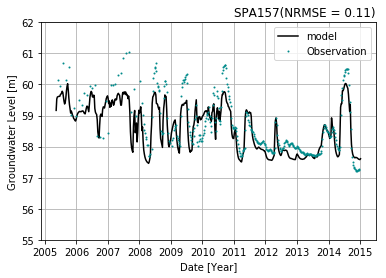

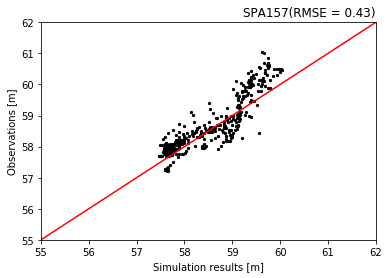

SPA168.pdf


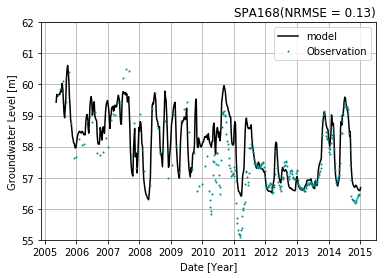

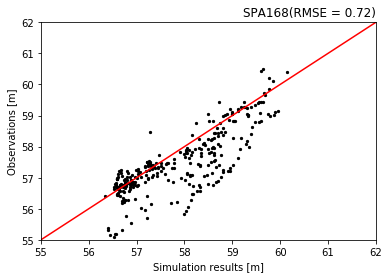

SPA165.pdf


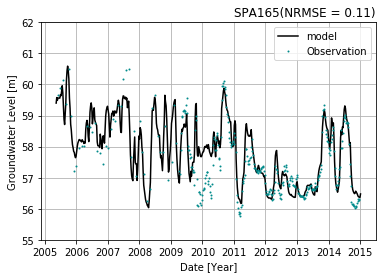

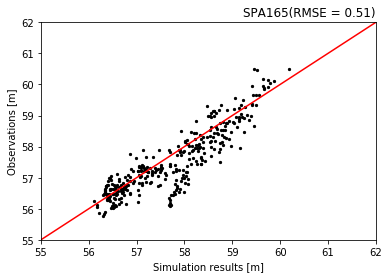

In [15]:
headobj = bf.HeadFile(os.path.join(workspace, modelname + '.hds'))

#observation wells

obs = [(1, 0, 65),
       (1, 0, 48),
       (1, 0, 46)]
name = ['SPA157','SPA168','SPA165']

for j in range (0,3):
    ts = headobj.get_ts ( idx= obs[j] )
    np.savetxt ( "HD.csv", ts, delimiter=',', header='Days,Head' )
    model = pd.read_csv ( 'HD.csv',delimiter=',')
    date = []
    for d in model['# Days']:
        date.append(datetime.datetime(2005,5,11)+datetime.timedelta(d-1)) 
    model['date'] = date
    model['nweek'] = np.int64((model['# Days']-1)/7+1)


   
    
    observation1 = pd.read_csv ( name[j]+'-weekly.csv' , delimiter=' ', header = -1)
    date = []
    for d in observation1.iloc[:,0]:
        date.append(datetime.datetime(2005,5,11)+datetime.timedelta((d-1)*7)) 
    observation1['date'] = date    
    observation1.columns = ['nweek','Head','date']
    observation1['Head'] = observation1['Head'] + 30

    plt.plot ( model['date'], model.iloc[:,1], label='model' , c = 'black')
    plt.plot( observation1['date'], observation1.iloc[:,1], '.', label='Observation1', markersize = 2, c='darkcyan' )
    plt.legend ( [ "model", "Observation" ] )
    plt.ylim(55,62)
    plt.xlabel ( 'Date [Year]' )
    plt.ylabel ( 'Groundwater Level [m]' )
    plt.grid(True)
    
    merge = pd.merge ( model, observation1,left_on='date',right_on='date',how='inner')
    merge = merge.iloc[:,[2,1,-1]]
    merge.columns = ['date','Head_model','Head_obs']
    
    h1 = merge['Head_model']
    h2 = merge['Head_obs']
    rmse = math.sqrt ( mse ( h1, h2 ) )
    nrmse = rmse/(np.max(h2)-np.min(h2))
    rmse = '{:01.2f}'.format(rmse)
    nrmse = '{:01.2f}'.format(nrmse)
    
    plt.title( name[j] + '(NRMSE = ' + str ( nrmse )+')', loc='right')
    title=name[j]+".pdf"
    print(title)
    #plt.savefig(title, dpi=300, bbox_inches='tight')
    plt.show ()
    
    
    u = []
    u = h1-h2
    a = h1 - h1

    
    x = [55,62]  
    y = [55,62]
    plt.scatter(h1,h2,s = 5,c='black')
    plt.plot(x,y,c='red')
    plt.ylim(55,62)
    plt.xlim(55,62)
    plt.xlabel('Simulation results [m]')
    plt.ylabel('Observations [m]')

    plt.title(name[j] + '(RMSE = ' + str ( rmse )+')', loc='right')
    title=name[j]+"2.pdf"
    #plt.savefig(title, dpi=300, bbox_inches='tight')
    plt.show()
    
    os.remove('HD.csv')



### MT3DMS 

In [16]:
if os.path.isfile('Basin-T-weekly.csv'):
    heat = pd.read_csv('Basin-T-weekly.csv',delimiter=' ',header = -1)
else:
    os.chdir("..")
    heat = pd.read_csv('Basin-T-weekly.csv',delimiter=' ',header = -1)

heat_basin = heat.iloc[:,-1].values

mt = flopy.mt3d.Mt3dms(modelname = 'heat',version='mt3dms',  exe_name='mt3dms5b', 
                       model_ws = workspace, 
                       modflowmodel = tm, ftlfilename = modelname + ".ftl", verbose = True)

adv = mt3.Mt3dAdv(mt, mixelm = -1, percel = 0.75)
icbund = np.ones((nlay, nrow, ncol), dtype=np.int32)
icbund[:,:,0] = -1
icbund[:,:,-1] = -1
sconc_1 = np.ones((nlay, nrow, ncol)) * 10

for i in range ( 30, 55):
    sconc_1[ :, :, i ] = 18
for i in range ( 38, 45):
    sconc_1[ :, :, i ] = 13.5
for i in range ( 30, 33):
    sconc_1[ 0, :, i] = 12
for i in range ( 50, 65):
    sconc_1[ 0, :, i] = 12
    
obs = [ ( 7, 0, 41)]

btn = mt3.Mt3dBtn(mt,icbund= icbund, ncomp=1,mcomp=0, sconc = sconc_1, prsity = sy, species_names=['heat'], obs=obs,
                nprobs=7)

dsp = mt3.Mt3dDsp(mt, al = 17, trpt= 0.1,trpv = 0.03, dmcoef= 0.17)

gcg = mt3.Mt3dGcg(mt, mxiter=1,iter1=50,isolve = 2,cclose = 1e-2,ncrs =1)             
rct = mt3.Mt3dRct(mt,isothm=1,ireact=0, prsity2= sy, igetsc=0, rhob = 1.87e3, sp1= 0.28e-3)


ssm_data = {}
ssm_data[0] = []

itype = flopy.mt3d.Mt3dSsm.itype_dict()

for i in range( 30, 33):
    ssm_data[0] = ssm_data[0]+ [[0, 0, i, 14 , itype[ 'GHB' ]]]
for i in range ( 50, 65):
    ssm_data[0].append( [ 0, 0, i, 14, itype[ 'GHB' ] ] )
    
for j in range (1,280):
    ssm_data[ j ] = [ ]
    for i in range ( 30, 33):
         ssm_data[ j ].append ( [ 0, 0, i, heat_basin[ j - 1 ], itype[ 'GHB' ] ] )
    for i in range ( 50, 65):
         ssm_data[ j ].append ( [ 0, 0, i, heat_basin[ j - 1 ], itype[ 'GHB' ] ] )
for j in range(280,nper):
    ssm_data[ j ] = [ ]
    for i in range ( 30, 33):
        ssm_data[ j ].append ( [ 0, 0, i, 14, itype[ 'GHB' ] ] )
    for i in range ( 50, 65):
        ssm_data[ j ].append ( [ 0, 0, i, 14, itype[ 'GHB' ] ] )

ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_data)

mt.write_input()
mt.run_model(silent = True)

Specified value of ftlfree conflicts with FTL file format
Switching ftlfree from False to True
adding Package:  ADV
adding Package:  BTN
adding Package:  DSP
adding Package:  GCG
adding Package:  RCT
adding Package:  SSM

Writing packages:
   Package:  ADV
   Package:  BTN
   Package:  DSP
   Package:  GCG
   Package:  RCT
   Package:  SSM
 


(False, [])

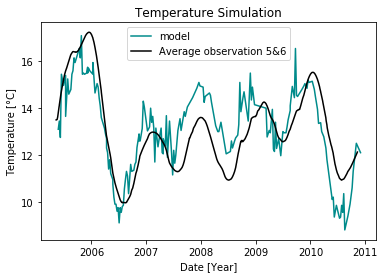

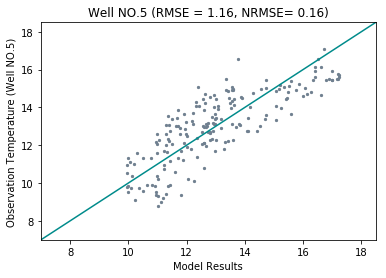

In [17]:
if os.path.isfile('N5_T-weekly2.csv'):
    n = pd.read_csv('N5_T-weekly2.csv',delimiter=',',header=0, index_col = 0)
    w = pd.read_csv('N6_T-weekly.csv',delimiter=',',header=0, index_col = 0)
else:
    os.chdir("..")
    n = pd.read_csv('N5_T-weekly2.csv',delimiter=',',header=0, index_col = 0)
    w = pd.read_csv('N6_T-weekly.csv',delimiter=',',header=0 ,index_col = 0)
if os.path.isfile('MT3D001.OBS'):
    t = pd.read_csv('MT3D001.OBS',delimiter=' ', nrows= 1150,skiprows=[0,1],skipinitialspace=True,skip_blank_lines=True,usecols=[1,2])

else:
    os.chdir(workspace)
    t = pd.read_csv('MT3D001.OBS',delimiter=' ', nrows= 1150,skiprows=[0,1],skipinitialspace=True,skip_blank_lines=True,usecols=[1,2])

t1 = t.iloc[:,0].values
y1 = []
for i in t1:
    y1.append([datetime.date(2005,5,11)+datetime.timedelta(i-1)])
t2 = t.iloc[:,1].values



n1 = n['days']
y2 = []
for i in n1:
    y2.append([datetime.date(2005,5,11)+datetime.timedelta(np.float64(i-1))])
n2 = n.iloc[:,0].values

w1 = w['days']
y3 = []
for i in w1:
    y3.append([datetime.date(2005,5,11)+datetime.timedelta(np.float64(i-1))])
w2 = w.iloc[:,0].values

plt.plot(y2,n2,c='darkcyan')
plt.plot(y1,t2,c='black')
plt.legend(['model','Average observation 5&6','ObservationN6'])
plt.xlabel ( 'Date [Year]' )
plt.ylabel ( 'Temperature [°C]' )
plt.title('Temperature Simulation')
plt.show()
plt.close()

x = pd.merge ( t, n,left_on= t.iloc[:,0].values,right_on='days',how='inner')

v1 = x.iloc[:,1].values
v2 = x.iloc[:,2].values
x1 = [7,18.5]
y1 = [7,18.5]
plt.scatter(v1,v2,s = 5,c='slategray')
plt.plot(x1,y1,c='darkcyan')
plt.ylim(7,18.5)
plt.xlim(7,18.5)
plt.xlabel ( 'Model Results' )
plt.ylabel ( 'Observation Temperature (Well NO.5)' )
rmse =  math.sqrt ( mse ( v1, v2 ) )
nrmse = rmse/(np.max(v2)-np.min(v1))
rmse = '{:01.2f}'.format(rmse)
nrmse= '{:01.2f}'.format(nrmse)
plt.title('Well NO.5 (RMSE = ' + str (rmse)+', NRMSE= '+ str(nrmse)+')')
plt.show()
plt.close()

### MODPATH 6

#### This is an Example for time series

In [18]:
mp = flopy.modpath.Modpath(modelname= modelname,
                               exe_name='C:/modflow/Packages/mp6',
                               modflowmodel= tm,
                               dis_file= tm.name  +'.dis',
                               head_file= tm.name +'.hds',
                               budget_file= tm.name + '.cbc',
                               )
options = [3,   #SimulationType           # 1 endpoint; 2 pathline; 3 timeseries
           1,   #TrackingDirection            # 1 forward; 2 backward
           1,   #WeakSinkOption            # 1 pass; 2 stop
           1,   #WeakSourceOption         # 1 pass; 2 stop
           1,   #ReferemceTimeOption       # 1 time value; 2 stress period, time step, relative offset
           1,   #StopOption                  # 1 stop with simulation 2; extend if steady state 3; specify time
           1,   #ParticleGenerationOption    # 1 automatic; 2 external file
           2,   #TimePointOption             # 1 none; 2 number at fixed intervals; 3 array
           1,   #BudgetOutputOption          # 1 none; 2 summary; 3 list of cells; 4 trace mode
           1,   #ZoneArrayOption          # 1 none; 2 read zone array(s) 
           1,   #RetardationOption           # 1 none; 2 read array(s) 
           1    #AdvectiveObservationsOption # 1 none; 2 saved for all time pts 3; saved for final time pt
          ] 
mpb = flopy.modpath.ModpathBas(mp, hdry=tm.lpf.hdry, laytyp=tm.lpf.laytyp, ibound=1, prsity = sy)

particles = 4 # particle numbers

ifaces = []
face_ct = []

group = []
group_placement = []
group_name = []

icnt = 0
for col in it.chain(range(30,33),range(50,65)):
    group_name.append('GHB{}'.format(icnt))
    group.append([0, 0, col, 0, 0, col])
    ifaces.append([[1, particles, particles], # side  
                   [2, particles, particles], # side 
                   [3, particles, particles], # side 
                   [4, particles, particles], # side 
                   [6, particles, particles]])# bottom
    face_ct.append(5)
    group_placement.append([1, 1, 1, 0, 1, 1])
    icnt += 1
    
sim = flopy.modpath.ModpathSim(mp, 
                 option_flags= options,
                 ref_time= 214, # the beginning time when you release the particles  
                 group_name=group_name, 
                 group_placement=group_placement,
                 group_region = group,  face_ct= face_ct,
                 ifaces=ifaces,
                 time_ct = 50  # the number of time steps needs to be read
                )
mp.write_input()
mp.run_model(silent=False)

FloPy is using the following  executable to run the model: C:/modflow/Packages/mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period    32.  Time =  2.18000E+02                                                                       
Processing Time Step     1 Period    33.  Time =  2.25000E+02                                                                       
Processing Time Step     1 Period    34.  Time =  2.32000E+02                                                                       
Processing Time Step     1 Period    35.  Time =  2.39000E+02                                                                       
Processing Time Step     1 Period    36.  Time =  2.46000E+02                                                                       
Processing Time Step     1 Period    37.  Time =  2.53000E+02                                                       

Processing Time Step     1 Period   441.  Time =  3.08100E+03                                                                       
Processing Time Step     1 Period   442.  Time =  3.08800E+03                                                                       
Processing Time Step     1 Period   443.  Time =  3.09500E+03                                                                       
Processing Time Step     1 Period   444.  Time =  3.10200E+03                                                                       
Processing Time Step     1 Period   445.  Time =  3.10900E+03                                                                       
Processing Time Step     1 Period   446.  Time =  3.11600E+03                                                                       
Processing Time Step     1 Period   447.  Time =  3.12300E+03                                                                       
Processing Time Step     1 Period   448.  Time =  3.13000E+03        

(True, [])

In [19]:
def modpath (t):
    mp = flopy.modpath.Modpath(modelname= modelname,
                               exe_name='C:/modflow/Packages/mp6',
                               modflowmodel= tm,
                               dis_file= tm.name  +'.dis',
                               head_file= tm.name +'.hds',
                               budget_file= tm.name + '.cbc',
                                   )
    options = [2,   #SimulationType           # 1 endpoint; 2 pathline; 3 timeseries
               1,   #TrackingDirection            # 1 forward; 2 backward
               1,   #WeakSinkOption            # 1 pass; 2 stop
               1,   #WeakSourceOption         # 1 pass; 2 stop
               1,   #ReferemceTimeOption       # 1 time value; 2 stress period, time step, relative offset
               1,   #StopOption                  # 1 stop with simulation 2; extend if steady state 3; specify time
               1,   #ParticleGenerationOption    # 1 automatic; 2 external file
               2,   #TimePointOption             # 1 none; 2 number at fixed intervals; 3 array
               1,   #BudgetOutputOption          # 1 none; 2 summary; 3 list of cells; 4 trace mode
               1,   #ZoneArrayOption          # 1 none; 2 read zone array(s) 
               1,   #RetardationOption           # 1 none; 2 read array(s) 
               1    #AdvectiveObservationsOption # 1 none; 2 saved for all time pts 3; saved for final time pt
              ] 
    mpb = flopy.modpath.ModpathBas(mp, hdry=tm.lpf.hdry, laytyp=tm.lpf.laytyp, ibound=1, prsity = sy)
    
    particles = 4 # particle numbers
    
    ifaces = []
    face_ct = []
    
    group = []
    group_placement = []
    group_name = []
    
    icnt = 0
    for col in it.chain(range(30,33),range(50,65)):
        group_name.append('GHB{}'.format(icnt))
        group.append([0, 0, col, 0, 0, col])
        ifaces.append([[1, particles, particles], # side  
                       [2, particles, particles], # side 
                       [3, particles, particles], # side 
                       [4, particles, particles], # side 
                       [6, particles, particles]])# bottom
        face_ct.append(5)
        group_placement.append([1, 1, 1, 0, 1, 1])
        icnt += 1
        
    sim = flopy.modpath.ModpathSim(mp, 
                     option_flags= options,
                     ref_time= t, # the beginning time when you release the particles  
                     group_name=group_name, 
                     group_placement=group_placement,
                     group_region = group,  face_ct= face_ct,
                     ifaces=ifaces,
                    )
    mp.write_input()
    mp.run_model(silent=False)
    pthobj = flopy.utils.PathlineFile(os.path.join(modelname +'.mppth'))
    pdobj = flopy.utils.EndpointFile(os.path.join(modelname +'.mpend'))
    shutil.copyfile ( modelname + '.mppth', str(t) + modelname + '.path' )
    shutil.copyfile ( modelname + '.mpend', str(t) + modelname + '.end' )
    
    
    options[0] = 3
    
    sim = flopy.modpath.ModpathSim(mp, 
                     option_flags= options,
                     ref_time= t, # the beginning time when you release the particles  
                     group_name=group_name, 
                     group_placement=group_placement,
                     group_region = group,  face_ct= face_ct,
                     ifaces=ifaces,
                     time_ct = 100  # the number of time steps needs to be read
                    )
    mp.write_input()
    mp.run_model(silent=False)        
    shutil.copyfile ( modelname + '.mp.tim_ser', str(t) + modelname + '.timeseries' )

In [20]:
time = [
    79,
    257,
    438,
    622,
    790,
    969,
    1152,
    1345,
    1538,
    1739
]
for i in time:
    modpath(round(i))

FloPy is using the following  executable to run the model: C:/modflow/Packages/mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period    13.  Time =  8.50000E+01                                                                       
Processing Time Step     1 Period    14.  Time =  9.20000E+01                                                                       
Processing Time Step     1 Period    15.  Time =  9.90000E+01                                                                       
Processing Time Step     1 Period    16.  Time =  1.06000E+02                                                                       
Processing Time Step     1 Period    17.  Time =  1.13000E+02                                                                       
Processing Time Step     1 Period    18.  Time =  1.20000E+02                                                       

Processing Time Step     1 Period    88.  Time =  6.10000E+02                                                                       
Processing Time Step     1 Period    89.  Time =  6.17000E+02                                                                       
Processing Time Step     1 Period    90.  Time =  6.24000E+02                                                                       
Processing Time Step     1 Period    91.  Time =  6.31000E+02                                                                       
Processing Time Step     1 Period    92.  Time =  6.38000E+02                                                                       
Processing Time Step     1 Period    93.  Time =  6.45000E+02                                                                       
Processing Time Step     1 Period    94.  Time =  6.52000E+02                                                                       
Processing Time Step     1 Period    95.  Time =  6.59000E+02        

Processing Time Step     1 Period   218.  Time =  1.52000E+03                                                                       
Processing Time Step     1 Period   219.  Time =  1.52700E+03                                                                       
Processing Time Step     1 Period   220.  Time =  1.53400E+03                                                                       
Processing Time Step     1 Period   221.  Time =  1.54100E+03                                                                       
Processing Time Step     1 Period   222.  Time =  1.54800E+03                                                                       
Processing Time Step     1 Period   223.  Time =  1.55500E+03                                                                       
Processing Time Step     1 Period   224.  Time =  1.56200E+03                                                                       
Processing Time Step     1 Period   225.  Time =  1.56900E+03        

Processing Time Step     1 Period   427.  Time =  2.98300E+03                                                                       
Processing Time Step     1 Period   428.  Time =  2.99000E+03                                                                       
Processing Time Step     1 Period   429.  Time =  2.99700E+03                                                                       
Processing Time Step     1 Period   430.  Time =  3.00400E+03                                                                       
Processing Time Step     1 Period   431.  Time =  3.01100E+03                                                                       
Processing Time Step     1 Period   432.  Time =  3.01800E+03                                                                       
Processing Time Step     1 Period   433.  Time =  3.02500E+03                                                                       
Processing Time Step     1 Period   434.  Time =  3.03200E+03        

****Warning -- two packages of the same type:  <class 'flopy.modpath.mpsim.ModpathSim'> <class 'flopy.modpath.mpsim.ModpathSim'>
replacing existing Package...
FloPy is using the following  executable to run the model: C:/modflow/Packages/mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period    13.  Time =  8.50000E+01                                                                       
Processing Time Step     1 Period    14.  Time =  9.20000E+01                                                                       
Processing Time Step     1 Period    15.  Time =  9.90000E+01                                                                       
Processing Time Step     1 Period    16.  Time =  1.06000E+02                                                                       
Processing Time Step     1 Period    17.  Time =  1.13000E+02                             

Processing Time Step     1 Period   178.  Time =  1.24000E+03                                                                       
Processing Time Step     1 Period   179.  Time =  1.24700E+03                                                                       
Processing Time Step     1 Period   180.  Time =  1.25400E+03                                                                       
Processing Time Step     1 Period   181.  Time =  1.26100E+03                                                                       
Processing Time Step     1 Period   182.  Time =  1.26800E+03                                                                       
Processing Time Step     1 Period   183.  Time =  1.27500E+03                                                                       
Processing Time Step     1 Period   184.  Time =  1.28200E+03                                                                       
Processing Time Step     1 Period   185.  Time =  1.28900E+03        

FloPy is using the following  executable to run the model: C:/modflow/Packages/mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period    38.  Time =  2.60000E+02                                                                       
Processing Time Step     1 Period    39.  Time =  2.67000E+02                                                                       
Processing Time Step     1 Period    40.  Time =  2.74000E+02                                                                       
Processing Time Step     1 Period    41.  Time =  2.81000E+02                                                                       
Processing Time Step     1 Period    42.  Time =  2.88000E+02                                                                       
Processing Time Step     1 Period    43.  Time =  2.95000E+02                                                       

Processing Time Step     1 Period   117.  Time =  8.13000E+02                                                                       
Processing Time Step     1 Period   118.  Time =  8.20000E+02                                                                       
Processing Time Step     1 Period   119.  Time =  8.27000E+02                                                                       
Processing Time Step     1 Period   120.  Time =  8.34000E+02                                                                       
Processing Time Step     1 Period   121.  Time =  8.41000E+02                                                                       
Processing Time Step     1 Period   122.  Time =  8.48000E+02                                                                       
Processing Time Step     1 Period   123.  Time =  8.55000E+02                                                                       
Processing Time Step     1 Period   124.  Time =  8.62000E+02        

Processing Time Step     1 Period   224.  Time =  1.56200E+03                                                                       
Processing Time Step     1 Period   225.  Time =  1.56900E+03                                                                       
Processing Time Step     1 Period   226.  Time =  1.57600E+03                                                                       
Processing Time Step     1 Period   227.  Time =  1.58300E+03                                                                       
Processing Time Step     1 Period   228.  Time =  1.59000E+03                                                                       
Processing Time Step     1 Period   229.  Time =  1.59700E+03                                                                       
Processing Time Step     1 Period   230.  Time =  1.60400E+03                                                                       
Processing Time Step     1 Period   231.  Time =  1.61100E+03        

Processing Time Step     1 Period   417.  Time =  2.91300E+03                                                                       
Processing Time Step     1 Period   418.  Time =  2.92000E+03                                                                       
Processing Time Step     1 Period   419.  Time =  2.92700E+03                                                                       
Processing Time Step     1 Period   420.  Time =  2.93400E+03                                                                       
Processing Time Step     1 Period   421.  Time =  2.94100E+03                                                                       
Processing Time Step     1 Period   422.  Time =  2.94800E+03                                                                       
Processing Time Step     1 Period   423.  Time =  2.95500E+03                                                                       
Processing Time Step     1 Period   424.  Time =  2.96200E+03        

****Warning -- two packages of the same type:  <class 'flopy.modpath.mpsim.ModpathSim'> <class 'flopy.modpath.mpsim.ModpathSim'>
replacing existing Package...
FloPy is using the following  executable to run the model: C:/modflow/Packages/mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period    38.  Time =  2.60000E+02                                                                       
Processing Time Step     1 Period    39.  Time =  2.67000E+02                                                                       
Processing Time Step     1 Period    40.  Time =  2.74000E+02                                                                       
Processing Time Step     1 Period    41.  Time =  2.81000E+02                                                                       
Processing Time Step     1 Period    42.  Time =  2.88000E+02                             

Processing Time Step     1 Period   394.  Time =  2.75200E+03                                                                       
Processing Time Step     1 Period   395.  Time =  2.75900E+03                                                                       
Processing Time Step     1 Period   396.  Time =  2.76600E+03                                                                       
Processing Time Step     1 Period   397.  Time =  2.77300E+03                                                                       
Processing Time Step     1 Period   398.  Time =  2.78000E+03                                                                       
Processing Time Step     1 Period   399.  Time =  2.78700E+03                                                                       
Processing Time Step     1 Period   400.  Time =  2.79400E+03                                                                       
Processing Time Step     1 Period   401.  Time =  2.80100E+03        

 
Run particle tracking simulation ...
Processing Time Step     1 Period    64.  Time =  4.42000E+02                                                                       
Processing Time Step     1 Period    65.  Time =  4.49000E+02                                                                       
Processing Time Step     1 Period    66.  Time =  4.56000E+02                                                                       
Processing Time Step     1 Period    67.  Time =  4.63000E+02                                                                       
Processing Time Step     1 Period    68.  Time =  4.70000E+02                                                                       
Processing Time Step     1 Period    69.  Time =  4.77000E+02                                                                       
Processing Time Step     1 Period    70.  Time =  4.84000E+02                                                                       
Processing Time Step     1 Per

Processing Time Step     1 Period   142.  Time =  9.88000E+02                                                                       
Processing Time Step     1 Period   143.  Time =  9.95000E+02                                                                       
Processing Time Step     1 Period   144.  Time =  1.00200E+03                                                                       
Processing Time Step     1 Period   145.  Time =  1.00900E+03                                                                       
Processing Time Step     1 Period   146.  Time =  1.01600E+03                                                                       
Processing Time Step     1 Period   147.  Time =  1.02300E+03                                                                       
Processing Time Step     1 Period   148.  Time =  1.03000E+03                                                                       
Processing Time Step     1 Period   149.  Time =  1.03700E+03        

Processing Time Step     1 Period   238.  Time =  1.66000E+03                                                                       
Processing Time Step     1 Period   239.  Time =  1.66700E+03                                                                       
Processing Time Step     1 Period   240.  Time =  1.67400E+03                                                                       
Processing Time Step     1 Period   241.  Time =  1.68100E+03                                                                       
Processing Time Step     1 Period   242.  Time =  1.68800E+03                                                                       
Processing Time Step     1 Period   243.  Time =  1.69500E+03                                                                       
Processing Time Step     1 Period   244.  Time =  1.70200E+03                                                                       
Processing Time Step     1 Period   245.  Time =  1.70900E+03        

Processing Time Step     1 Period   378.  Time =  2.64000E+03                                                                       
Processing Time Step     1 Period   379.  Time =  2.64700E+03                                                                       
Processing Time Step     1 Period   380.  Time =  2.65400E+03                                                                       
Processing Time Step     1 Period   381.  Time =  2.66100E+03                                                                       
Processing Time Step     1 Period   382.  Time =  2.66800E+03                                                                       
Processing Time Step     1 Period   383.  Time =  2.67500E+03                                                                       
Processing Time Step     1 Period   384.  Time =  2.68200E+03                                                                       
Processing Time Step     1 Period   385.  Time =  2.68900E+03        

****Warning -- two packages of the same type:  <class 'flopy.modpath.mpsim.ModpathSim'> <class 'flopy.modpath.mpsim.ModpathSim'>
replacing existing Package...
FloPy is using the following  executable to run the model: C:/modflow/Packages/mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period    64.  Time =  4.42000E+02                                                                       
Processing Time Step     1 Period    65.  Time =  4.49000E+02                                                                       
Processing Time Step     1 Period    66.  Time =  4.56000E+02                                                                       
Processing Time Step     1 Period    67.  Time =  4.63000E+02                                                                       
Processing Time Step     1 Period    68.  Time =  4.70000E+02                             

Processing Time Step     1 Period   469.  Time =  3.27700E+03                                                                       
Processing Time Step     1 Period   470.  Time =  3.28400E+03                                                                       
Processing Time Step     1 Period   471.  Time =  3.29100E+03                                                                       
Processing Time Step     1 Period   472.  Time =  3.29800E+03                                                                       
Processing Time Step     1 Period   473.  Time =  3.30500E+03                                                                       
Processing Time Step     1 Period   474.  Time =  3.31200E+03                                                                       
Processing Time Step     1 Period   475.  Time =  3.31900E+03                                                                       
Processing Time Step     1 Period   476.  Time =  3.32600E+03        

Processing Time Step     1 Period   117.  Time =  8.13000E+02                                                                       
Processing Time Step     1 Period   118.  Time =  8.20000E+02                                                                       
Processing Time Step     1 Period   119.  Time =  8.27000E+02                                                                       
Processing Time Step     1 Period   120.  Time =  8.34000E+02                                                                       
Processing Time Step     1 Period   121.  Time =  8.41000E+02                                                                       
Processing Time Step     1 Period   122.  Time =  8.48000E+02                                                                       
Processing Time Step     1 Period   123.  Time =  8.55000E+02                                                                       
Processing Time Step     1 Period   124.  Time =  8.62000E+02        

Processing Time Step     1 Period   185.  Time =  1.28900E+03                                                                       
Processing Time Step     1 Period   186.  Time =  1.29600E+03                                                                       
Processing Time Step     1 Period   187.  Time =  1.30300E+03                                                                       
Processing Time Step     1 Period   188.  Time =  1.31000E+03                                                                       
Processing Time Step     1 Period   189.  Time =  1.31700E+03                                                                       
Processing Time Step     1 Period   190.  Time =  1.32400E+03                                                                       
Processing Time Step     1 Period   191.  Time =  1.33100E+03                                                                       
Processing Time Step     1 Period   192.  Time =  1.33800E+03        

Processing Time Step     1 Period   250.  Time =  1.74400E+03                                                                       
Processing Time Step     1 Period   251.  Time =  1.75100E+03                                                                       
Processing Time Step     1 Period   252.  Time =  1.75800E+03                                                                       
Processing Time Step     1 Period   253.  Time =  1.76500E+03                                                                       
Processing Time Step     1 Period   254.  Time =  1.77200E+03                                                                       
Processing Time Step     1 Period   255.  Time =  1.77900E+03                                                                       
Processing Time Step     1 Period   256.  Time =  1.78600E+03                                                                       
Processing Time Step     1 Period   257.  Time =  1.79300E+03        

Processing Time Step     1 Period   322.  Time =  2.24800E+03                                                                       
Processing Time Step     1 Period   323.  Time =  2.25500E+03                                                                       
Processing Time Step     1 Period   324.  Time =  2.26200E+03                                                                       
Processing Time Step     1 Period   325.  Time =  2.26900E+03                                                                       
Processing Time Step     1 Period   326.  Time =  2.27600E+03                                                                       
Processing Time Step     1 Period   327.  Time =  2.28300E+03                                                                       
Processing Time Step     1 Period   328.  Time =  2.29000E+03                                                                       
Processing Time Step     1 Period   329.  Time =  2.29700E+03        

Processing Time Step     1 Period   482.  Time =  3.36800E+03                                                                       
Processing Time Step     1 Period   483.  Time =  3.37500E+03                                                                       
Processing Time Step     1 Period   484.  Time =  3.38200E+03                                                                       
Processing Time Step     1 Period   485.  Time =  3.38900E+03                                                                       
Processing Time Step     1 Period   486.  Time =  3.39600E+03                                                                       
Processing Time Step     1 Period   487.  Time =  3.40300E+03                                                                       
Processing Time Step     1 Period   488.  Time =  3.41000E+03                                                                       
Processing Time Step     1 Period   489.  Time =  3.41700E+03        

Processing Time Step     1 Period   342.  Time =  2.38800E+03                                                                       
Processing Time Step     1 Period   343.  Time =  2.39500E+03                                                                       
Processing Time Step     1 Period   344.  Time =  2.40200E+03                                                                       
Processing Time Step     1 Period   345.  Time =  2.40900E+03                                                                       
Processing Time Step     1 Period   346.  Time =  2.41600E+03                                                                       
Processing Time Step     1 Period   347.  Time =  2.42300E+03                                                                       
Processing Time Step     1 Period   348.  Time =  2.43000E+03                                                                       
Processing Time Step     1 Period   349.  Time =  2.43700E+03        

 
Run particle tracking simulation ...
Processing Time Step     1 Period   114.  Time =  7.92000E+02                                                                       
Processing Time Step     1 Period   115.  Time =  7.99000E+02                                                                       
Processing Time Step     1 Period   116.  Time =  8.06000E+02                                                                       
Processing Time Step     1 Period   117.  Time =  8.13000E+02                                                                       
Processing Time Step     1 Period   118.  Time =  8.20000E+02                                                                       
Processing Time Step     1 Period   119.  Time =  8.27000E+02                                                                       
Processing Time Step     1 Period   120.  Time =  8.34000E+02                                                                       
Processing Time Step     1 Per

Processing Time Step     1 Period   180.  Time =  1.25400E+03                                                                       
Processing Time Step     1 Period   181.  Time =  1.26100E+03                                                                       
Processing Time Step     1 Period   182.  Time =  1.26800E+03                                                                       
Processing Time Step     1 Period   183.  Time =  1.27500E+03                                                                       
Processing Time Step     1 Period   184.  Time =  1.28200E+03                                                                       
Processing Time Step     1 Period   185.  Time =  1.28900E+03                                                                       
Processing Time Step     1 Period   186.  Time =  1.29600E+03                                                                       
Processing Time Step     1 Period   187.  Time =  1.30300E+03        

Processing Time Step     1 Period   247.  Time =  1.72300E+03                                                                       
Processing Time Step     1 Period   248.  Time =  1.73000E+03                                                                       
Processing Time Step     1 Period   249.  Time =  1.73700E+03                                                                       
Processing Time Step     1 Period   250.  Time =  1.74400E+03                                                                       
Processing Time Step     1 Period   251.  Time =  1.75100E+03                                                                       
Processing Time Step     1 Period   252.  Time =  1.75800E+03                                                                       
Processing Time Step     1 Period   253.  Time =  1.76500E+03                                                                       
Processing Time Step     1 Period   254.  Time =  1.77200E+03        

Processing Time Step     1 Period   390.  Time =  2.72400E+03                                                                       
Processing Time Step     1 Period   391.  Time =  2.73100E+03                                                                       
Processing Time Step     1 Period   392.  Time =  2.73800E+03                                                                       
Processing Time Step     1 Period   393.  Time =  2.74500E+03                                                                       
Processing Time Step     1 Period   394.  Time =  2.75200E+03                                                                       
Processing Time Step     1 Period   395.  Time =  2.75900E+03                                                                       
Processing Time Step     1 Period   396.  Time =  2.76600E+03                                                                       
Processing Time Step     1 Period   397.  Time =  2.77300E+03        

End of MODPATH simulation. Normal termination.
****Warning -- two packages of the same type:  <class 'flopy.modpath.mpsim.ModpathSim'> <class 'flopy.modpath.mpsim.ModpathSim'>
replacing existing Package...
FloPy is using the following  executable to run the model: C:/modflow/Packages/mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period   114.  Time =  7.92000E+02                                                                       
Processing Time Step     1 Period   115.  Time =  7.99000E+02                                                                       
Processing Time Step     1 Period   116.  Time =  8.06000E+02                                                                       
Processing Time Step     1 Period   117.  Time =  8.13000E+02                                                                       
Processing Time Step     1 Period   118.  T

Processing Time Step     1 Period   452.  Time =  3.15800E+03                                                                       
Processing Time Step     1 Period   453.  Time =  3.16500E+03                                                                       
Processing Time Step     1 Period   454.  Time =  3.17200E+03                                                                       
Processing Time Step     1 Period   455.  Time =  3.17900E+03                                                                       
Processing Time Step     1 Period   456.  Time =  3.18600E+03                                                                       
Processing Time Step     1 Period   457.  Time =  3.19300E+03                                                                       
Processing Time Step     1 Period   458.  Time =  3.20000E+03                                                                       
Processing Time Step     1 Period   459.  Time =  3.20700E+03        

Processing Time Step     1 Period   145.  Time =  1.00900E+03                                                                       
Processing Time Step     1 Period   146.  Time =  1.01600E+03                                                                       
Processing Time Step     1 Period   147.  Time =  1.02300E+03                                                                       
Processing Time Step     1 Period   148.  Time =  1.03000E+03                                                                       
Processing Time Step     1 Period   149.  Time =  1.03700E+03                                                                       
Processing Time Step     1 Period   150.  Time =  1.04400E+03                                                                       
Processing Time Step     1 Period   151.  Time =  1.05100E+03                                                                       
Processing Time Step     1 Period   152.  Time =  1.05800E+03        

Processing Time Step     1 Period   236.  Time =  1.64600E+03                                                                       
Processing Time Step     1 Period   237.  Time =  1.65300E+03                                                                       
Processing Time Step     1 Period   238.  Time =  1.66000E+03                                                                       
Processing Time Step     1 Period   239.  Time =  1.66700E+03                                                                       
Processing Time Step     1 Period   240.  Time =  1.67400E+03                                                                       
Processing Time Step     1 Period   241.  Time =  1.68100E+03                                                                       
Processing Time Step     1 Period   242.  Time =  1.68800E+03                                                                       
Processing Time Step     1 Period   243.  Time =  1.69500E+03        

Processing Time Step     1 Period   310.  Time =  2.16400E+03                                                                       
Processing Time Step     1 Period   311.  Time =  2.17100E+03                                                                       
Processing Time Step     1 Period   312.  Time =  2.17800E+03                                                                       
Processing Time Step     1 Period   313.  Time =  2.18500E+03                                                                       
Processing Time Step     1 Period   314.  Time =  2.19200E+03                                                                       
Processing Time Step     1 Period   315.  Time =  2.19900E+03                                                                       
Processing Time Step     1 Period   316.  Time =  2.20600E+03                                                                       
Processing Time Step     1 Period   317.  Time =  2.21300E+03        

Processing Time Step     1 Period   392.  Time =  2.73800E+03                                                                       
Processing Time Step     1 Period   393.  Time =  2.74500E+03                                                                       
Processing Time Step     1 Period   394.  Time =  2.75200E+03                                                                       
Processing Time Step     1 Period   395.  Time =  2.75900E+03                                                                       
Processing Time Step     1 Period   396.  Time =  2.76600E+03                                                                       
Processing Time Step     1 Period   397.  Time =  2.77300E+03                                                                       
Processing Time Step     1 Period   398.  Time =  2.78000E+03                                                                       
Processing Time Step     1 Period   399.  Time =  2.78700E+03        

End of MODPATH simulation. Normal termination.
****Warning -- two packages of the same type:  <class 'flopy.modpath.mpsim.ModpathSim'> <class 'flopy.modpath.mpsim.ModpathSim'>
replacing existing Package...
FloPy is using the following  executable to run the model: C:/modflow/Packages/mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period   140.  Time =  9.74000E+02                                                                       
Processing Time Step     1 Period   141.  Time =  9.81000E+02                                                                       
Processing Time Step     1 Period   142.  Time =  9.88000E+02                                                                       
Processing Time Step     1 Period   143.  Time =  9.95000E+02                                                                       
Processing Time Step     1 Period   144.  T

FloPy is using the following  executable to run the model: C:/modflow/Packages/mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period   166.  Time =  1.15600E+03                                                                       
Processing Time Step     1 Period   167.  Time =  1.16300E+03                                                                       
Processing Time Step     1 Period   168.  Time =  1.17000E+03                                                                       
Processing Time Step     1 Period   169.  Time =  1.17700E+03                                                                       
Processing Time Step     1 Period   170.  Time =  1.18400E+03                                                                       
Processing Time Step     1 Period   171.  Time =  1.19100E+03                                                       

Processing Time Step     1 Period   226.  Time =  1.57600E+03                                                                       
Processing Time Step     1 Period   227.  Time =  1.58300E+03                                                                       
Processing Time Step     1 Period   228.  Time =  1.59000E+03                                                                       
Processing Time Step     1 Period   229.  Time =  1.59700E+03                                                                       
Processing Time Step     1 Period   230.  Time =  1.60400E+03                                                                       
Processing Time Step     1 Period   231.  Time =  1.61100E+03                                                                       
Processing Time Step     1 Period   232.  Time =  1.61800E+03                                                                       
Processing Time Step     1 Period   233.  Time =  1.62500E+03        

Processing Time Step     1 Period   303.  Time =  2.11500E+03                                                                       
Processing Time Step     1 Period   304.  Time =  2.12200E+03                                                                       
Processing Time Step     1 Period   305.  Time =  2.12900E+03                                                                       
Processing Time Step     1 Period   306.  Time =  2.13600E+03                                                                       
Processing Time Step     1 Period   307.  Time =  2.14300E+03                                                                       
Processing Time Step     1 Period   308.  Time =  2.15000E+03                                                                       
Processing Time Step     1 Period   309.  Time =  2.15700E+03                                                                       
Processing Time Step     1 Period   310.  Time =  2.16400E+03        

Processing Time Step     1 Period   406.  Time =  2.83600E+03                                                                       
Processing Time Step     1 Period   407.  Time =  2.84300E+03                                                                       
Processing Time Step     1 Period   408.  Time =  2.85000E+03                                                                       
Processing Time Step     1 Period   409.  Time =  2.85700E+03                                                                       
Processing Time Step     1 Period   410.  Time =  2.86400E+03                                                                       
Processing Time Step     1 Period   411.  Time =  2.87100E+03                                                                       
Processing Time Step     1 Period   412.  Time =  2.87800E+03                                                                       
Processing Time Step     1 Period   413.  Time =  2.88500E+03        

Processing Time Step     1 Period   482.  Time =  3.36800E+03                                                                       
Processing Time Step     1 Period   483.  Time =  3.37500E+03                                                                       
Processing Time Step     1 Period   484.  Time =  3.38200E+03                                                                       
Processing Time Step     1 Period   485.  Time =  3.38900E+03                                                                       
Processing Time Step     1 Period   486.  Time =  3.39600E+03                                                                       
Processing Time Step     1 Period   487.  Time =  3.40300E+03                                                                       
Processing Time Step     1 Period   488.  Time =  3.41000E+03                                                                       
Processing Time Step     1 Period   489.  Time =  3.41700E+03        

FloPy is using the following  executable to run the model: C:/modflow/Packages/mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period   193.  Time =  1.34500E+03                                                                       
Processing Time Step     1 Period   194.  Time =  1.35200E+03                                                                       
Processing Time Step     1 Period   195.  Time =  1.35900E+03                                                                       
Processing Time Step     1 Period   196.  Time =  1.36600E+03                                                                       
Processing Time Step     1 Period   197.  Time =  1.37300E+03                                                                       
Processing Time Step     1 Period   198.  Time =  1.38000E+03                                                       

Processing Time Step     1 Period   269.  Time =  1.87700E+03                                                                       
Processing Time Step     1 Period   270.  Time =  1.88400E+03                                                                       
Processing Time Step     1 Period   271.  Time =  1.89100E+03                                                                       
Processing Time Step     1 Period   272.  Time =  1.89800E+03                                                                       
Processing Time Step     1 Period   273.  Time =  1.90500E+03                                                                       
Processing Time Step     1 Period   274.  Time =  1.91200E+03                                                                       
Processing Time Step     1 Period   275.  Time =  1.91900E+03                                                                       
Processing Time Step     1 Period   276.  Time =  1.92600E+03        

Processing Time Step     1 Period   336.  Time =  2.34600E+03                                                                       
Processing Time Step     1 Period   337.  Time =  2.35300E+03                                                                       
Processing Time Step     1 Period   338.  Time =  2.36000E+03                                                                       
Processing Time Step     1 Period   339.  Time =  2.36700E+03                                                                       
Processing Time Step     1 Period   340.  Time =  2.37400E+03                                                                       
Processing Time Step     1 Period   341.  Time =  2.38100E+03                                                                       
Processing Time Step     1 Period   342.  Time =  2.38800E+03                                                                       
Processing Time Step     1 Period   343.  Time =  2.39500E+03        

Processing Time Step     1 Period   414.  Time =  2.89200E+03                                                                       
Processing Time Step     1 Period   415.  Time =  2.89900E+03                                                                       
Processing Time Step     1 Period   416.  Time =  2.90600E+03                                                                       
Processing Time Step     1 Period   417.  Time =  2.91300E+03                                                                       
Processing Time Step     1 Period   418.  Time =  2.92000E+03                                                                       
Processing Time Step     1 Period   419.  Time =  2.92700E+03                                                                       
Processing Time Step     1 Period   420.  Time =  2.93400E+03                                                                       
Processing Time Step     1 Period   421.  Time =  2.94100E+03        

Processing Time Step     1 Period   495.  Time =  3.45900E+03                                                                       
Processing Time Step     1 Period   496.  Time =  3.46600E+03                                                                       
Processing Time Step     1 Period   497.  Time =  3.47300E+03                                                                       
Processing Time Step     1 Period   498.  Time =  3.48000E+03                                                                       
Processing Time Step     1 Period   499.  Time =  3.48700E+03                                                                       
Processing Time Step     1 Period   500.  Time =  3.49400E+03                                                                       
Processing Time Step     1 Period   501.  Time =  3.50100E+03                                                                       
Processing Time Step     1 Period   502.  Time =  3.50800E+03        

Processing Time Step     1 Period   444.  Time =  3.10200E+03                                                                       
Processing Time Step     1 Period   445.  Time =  3.10900E+03                                                                       
Processing Time Step     1 Period   446.  Time =  3.11600E+03                                                                       
Processing Time Step     1 Period   447.  Time =  3.12300E+03                                                                       
Processing Time Step     1 Period   448.  Time =  3.13000E+03                                                                       
Processing Time Step     1 Period   449.  Time =  3.13700E+03                                                                       
Processing Time Step     1 Period   450.  Time =  3.14400E+03                                                                       
Processing Time Step     1 Period   451.  Time =  3.15100E+03        

 
Run particle tracking simulation ...
Processing Time Step     1 Period   221.  Time =  1.54100E+03                                                                       
Processing Time Step     1 Period   222.  Time =  1.54800E+03                                                                       
Processing Time Step     1 Period   223.  Time =  1.55500E+03                                                                       
Processing Time Step     1 Period   224.  Time =  1.56200E+03                                                                       
Processing Time Step     1 Period   225.  Time =  1.56900E+03                                                                       
Processing Time Step     1 Period   226.  Time =  1.57600E+03                                                                       
Processing Time Step     1 Period   227.  Time =  1.58300E+03                                                                       
Processing Time Step     1 Per

Processing Time Step     1 Period   302.  Time =  2.10800E+03                                                                       
Processing Time Step     1 Period   303.  Time =  2.11500E+03                                                                       
Processing Time Step     1 Period   304.  Time =  2.12200E+03                                                                       
Processing Time Step     1 Period   305.  Time =  2.12900E+03                                                                       
Processing Time Step     1 Period   306.  Time =  2.13600E+03                                                                       
Processing Time Step     1 Period   307.  Time =  2.14300E+03                                                                       
Processing Time Step     1 Period   308.  Time =  2.15000E+03                                                                       
Processing Time Step     1 Period   309.  Time =  2.15700E+03        

Processing Time Step     1 Period   372.  Time =  2.59800E+03                                                                       
Processing Time Step     1 Period   373.  Time =  2.60500E+03                                                                       
Processing Time Step     1 Period   374.  Time =  2.61200E+03                                                                       
Processing Time Step     1 Period   375.  Time =  2.61900E+03                                                                       
Processing Time Step     1 Period   376.  Time =  2.62600E+03                                                                       
Processing Time Step     1 Period   377.  Time =  2.63300E+03                                                                       
Processing Time Step     1 Period   378.  Time =  2.64000E+03                                                                       
Processing Time Step     1 Period   379.  Time =  2.64700E+03        

Processing Time Step     1 Period   449.  Time =  3.13700E+03                                                                       
Processing Time Step     1 Period   450.  Time =  3.14400E+03                                                                       
Processing Time Step     1 Period   451.  Time =  3.15100E+03                                                                       
Processing Time Step     1 Period   452.  Time =  3.15800E+03                                                                       
Processing Time Step     1 Period   453.  Time =  3.16500E+03                                                                       
Processing Time Step     1 Period   454.  Time =  3.17200E+03                                                                       
Processing Time Step     1 Period   455.  Time =  3.17900E+03                                                                       
Processing Time Step     1 Period   456.  Time =  3.18600E+03        

Processing Time Step     1 Period   223.  Time =  1.55500E+03                                                                       
Processing Time Step     1 Period   224.  Time =  1.56200E+03                                                                       
Processing Time Step     1 Period   225.  Time =  1.56900E+03                                                                       
Processing Time Step     1 Period   226.  Time =  1.57600E+03                                                                       
Processing Time Step     1 Period   227.  Time =  1.58300E+03                                                                       
Processing Time Step     1 Period   228.  Time =  1.59000E+03                                                                       
Processing Time Step     1 Period   229.  Time =  1.59700E+03                                                                       
Processing Time Step     1 Period   230.  Time =  1.60400E+03        

Processing Time Step     1 Period   453.  Time =  3.16500E+03                                                                       
Processing Time Step     1 Period   454.  Time =  3.17200E+03                                                                       
Processing Time Step     1 Period   455.  Time =  3.17900E+03                                                                       
Processing Time Step     1 Period   456.  Time =  3.18600E+03                                                                       
Processing Time Step     1 Period   457.  Time =  3.19300E+03                                                                       
Processing Time Step     1 Period   458.  Time =  3.20000E+03                                                                       
Processing Time Step     1 Period   459.  Time =  3.20700E+03                                                                       
Processing Time Step     1 Period   460.  Time =  3.21400E+03        

Processing Time Step     1 Period   256.  Time =  1.78600E+03                                                                       
Processing Time Step     1 Period   257.  Time =  1.79300E+03                                                                       
Processing Time Step     1 Period   258.  Time =  1.80000E+03                                                                       
Processing Time Step     1 Period   259.  Time =  1.80700E+03                                                                       
Processing Time Step     1 Period   260.  Time =  1.81400E+03                                                                       
Processing Time Step     1 Period   261.  Time =  1.82100E+03                                                                       
Processing Time Step     1 Period   262.  Time =  1.82800E+03                                                                       
Processing Time Step     1 Period   263.  Time =  1.83500E+03        

Processing Time Step     1 Period   326.  Time =  2.27600E+03                                                                       
Processing Time Step     1 Period   327.  Time =  2.28300E+03                                                                       
Processing Time Step     1 Period   328.  Time =  2.29000E+03                                                                       
Processing Time Step     1 Period   329.  Time =  2.29700E+03                                                                       
Processing Time Step     1 Period   330.  Time =  2.30400E+03                                                                       
Processing Time Step     1 Period   331.  Time =  2.31100E+03                                                                       
Processing Time Step     1 Period   332.  Time =  2.31800E+03                                                                       
Processing Time Step     1 Period   333.  Time =  2.32500E+03        

Processing Time Step     1 Period   415.  Time =  2.89900E+03                                                                       
Processing Time Step     1 Period   416.  Time =  2.90600E+03                                                                       
Processing Time Step     1 Period   417.  Time =  2.91300E+03                                                                       
Processing Time Step     1 Period   418.  Time =  2.92000E+03                                                                       
Processing Time Step     1 Period   419.  Time =  2.92700E+03                                                                       
Processing Time Step     1 Period   420.  Time =  2.93400E+03                                                                       
Processing Time Step     1 Period   421.  Time =  2.94100E+03                                                                       
Processing Time Step     1 Period   422.  Time =  2.94800E+03        

Processing Time Step     1 Period   501.  Time =  3.50100E+03                                                                       
Processing Time Step     1 Period   502.  Time =  3.50800E+03                                                                       
Processing Time Step     1 Period   503.  Time =  3.51500E+03                                                                       
Processing Time Step     1 Period   504.  Time =  3.52200E+03                                                                       
Processing Time Step     1 Period   505.  Time =  3.52900E+03                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.
****Warning -- two packages of the same type:  <class 'flopy.modpath.mpsim.ModpathSim'> <class 'flopy.modpath.mpsim.ModpathSim'>
replacing existing Package

End of MODPATH simulation. Normal termination.
